In [1]:
import torch
import cvxpy as cvx
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bound(n_dim,p):

    dx = 0.001
    x = np.arange(0, n_dim,dx)

    cdf = np.cumsum(chi2.pdf(x, df=n_dim)*dx)
    bound = max(x[cdf<=p])

    return bound

In [3]:
n_dim = 100
mu = np.random.rand(n_dim)
A = 0.25 * np.random.rand(n_dim,n_dim) +  0.25 *mu
Corr = np.random.rand(n_dim) 
Corr = np.diag(Corr)

Sigma = A.T @ A 



In [4]:
# eigvals,P = np.linalg.eigh(Sigma)
# D = np.diag(eigvals)
# D_inv = np.diag(1/eigvals)

# Sigma_inv = P.T @ D_inv @ P

# #(P @ D @ P.T) @ (P @ D_inv @ P.T)

# np.max(Sigma - (P @ D @ P.T))


In [5]:
def sparsify_grad(mu,Sigma):


    n_dim = mu.shape[0]
    
    eigvals,P = np.linalg.eigh(Sigma)
    assert (eigvals >= 0).all()

    
    ### Square root of Sigma_inv

    D = np.diag(1/eigvals)
    D_sqrt = np.diag(np.sqrt(1/eigvals))
    P_p = P.T@D_sqrt 

    
    ###################

    C = get_bound(n_dim,p=0.05)

    x = cvx.Variable((n_dim))
    objective = cvx.Minimize(cvx.norm(x,1))
    pb = cvx.Problem(objective,
                    [cvx.sum_squares(P_p@x -P_p@mu) <= C])

    pb.solve(verbose=False)

    rslt = x.value

    assert all(rslt<=mu)

    relative_diff = abs(rslt-mu)/mu

    plt.hist(relative_diff)

    return np.sum(relative_diff>0.9), np.sum(relative_diff<0.1),np.sum(relative_diff<0.5)


(79, 6, 14)

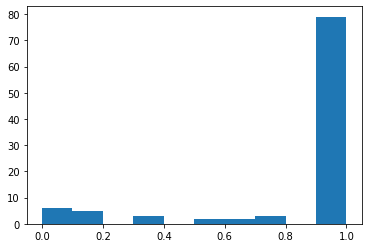

In [6]:
sparsify_grad(mu,Sigma)

In [7]:
def qcl1(A, b):
    """
    Returns the solution u, z of

        (primal)  minimize    || u ||_1
                  subject to  || A * u - b ||_2  <= 1

        (dual)    maximize    b^T z - ||z||_2
                  subject to  || A'*z ||_inf <= 1.

    Exploits structure, assuming A is m by n with m >= n.
    """

    m, n = A.shape

    # Solve equivalent cone LP with variables x = [u; v].
    #
    #     minimize    [0; 1]' * x
    #     subject to  [ I  -I ] * x <=  [  0 ]   (componentwise)
    #                 [-I  -I ] * x <=  [  0 ]   (componentwise)
    #                 [ 0   0 ] * x <=  [  1 ]   (SOC)
    #                 [-A   0 ]         [ -b ]
    #
    #     maximize    -t + b' * w
    #     subject to  z1 - z2 = A'*w
    #                 z1 + z2 = 1
    #                 z1 >= 0,  z2 >=0,  ||w||_2 <= t.

    c = matrix(n*[0.0] + n*[1.0])
    h = matrix( 0.0, (2*n + m + 1, 1))
    h[2*n] = 1.0
    h[2*n+1:] = -b

    def G(x, y, alpha = 1.0, beta = 0.0, trans = 'N'):
        y *= beta
        if trans=='N':
            # y += alpha * G * x
            y[:n] += alpha * (x[:n] - x[n:2*n])
            y[n:2*n] += alpha * (-x[:n] - x[n:2*n])
            y[2*n+1:] -= alpha * A*x[:n]

        else:
            # y += alpha * G'*x
            y[:n] += alpha * (x[:n] - x[n:2*n] - A.T * x[-m:])
            y[n:] -= alpha * (x[:n] + x[n:2*n])


    def Fkkt(W):
        """
        Returns a function f(x, y, z) that solves

            [ 0   G'   ] [ x ] = [ bx ]
            [ G  -W'*W ] [ z ]   [ bz ].
        """

        # First factor
        #
        #     S = G' * W**-1 * W**-T * G
        #       = [0; -A]' * W3^-2 * [0; -A] + 4 * (W1**2 + W2**2)**-1
        #
        # where
        #
        #     W1 = diag(d1) with d1 = W['d'][:n] = 1 ./ W['di'][:n]
        #     W2 = diag(d2) with d2 = W['d'][n:] = 1 ./ W['di'][n:]
        #     W3 = beta * (2*v*v' - J),  W3^-1 = 1/beta * (2*J*v*v'*J - J)
        #        with beta = W['beta'][0], v = W['v'][0], J = [1, 0; 0, -I].

        # As = W3^-1 * [ 0 ; -A ] = 1/beta * ( 2*J*v * v' - I ) * [0; A]
        beta, v = W['beta'][0], W['v'][0]
        As = 2 * v * (v[1:].T * A)
        As[1:,:] *= -1.0
        As[1:,:] -= A
        As /= beta

        # S = As'*As + 4 * (W1**2 + W2**2)**-1
        S = As.T * As
        d1, d2 = W['d'][:n], W['d'][n:]
        d = 4.0 * (d1**2 + d2**2)**-1
        S[::n+1] += d
        lapack.potrf(S)

        def f(x, y, z):

            # z := - W**-T * z
            z[:n] = -div( z[:n], d1 )
            z[n:2*n] = -div( z[n:2*n], d2 )
            z[2*n:] -= 2.0*v*( v[0]*z[2*n] - blas.dot(v[1:], z[2*n+1:]) )
            z[2*n+1:] *= -1.0
            z[2*n:] /= beta

            # x := x - G' * W**-1 * z
            x[:n] -= div(z[:n], d1) - div(z[n:2*n], d2) + As.T * z[-(m+1):]
            x[n:] += div(z[:n], d1) + div(z[n:2*n], d2)

            # Solve for x[:n]:
            #
            #    S*x[:n] = x[:n] - (W1**2 - W2**2)(W1**2 + W2**2)^-1 * x[n:]

            x[:n] -= mul( div(d1**2 - d2**2, d1**2 + d2**2), x[n:])
            lapack.potrs(S, x)

            # Solve for x[n:]:
            #
            #    (d1**-2 + d2**-2) * x[n:] = x[n:] + (d1**-2 - d2**-2)*x[:n]

            x[n:] += mul( d1**-2 - d2**-2, x[:n])
            x[n:] = div( x[n:], d1**-2 + d2**-2)

            # z := z + W^-T * G*x
            z[:n] += div( x[:n] - x[n:2*n], d1)
            z[n:2*n] += div( -x[:n] - x[n:2*n], d2)
            z[2*n:] += As*x[:n]

        return f

    dims = {'l': 2*n, 'q': [m+1], 's': []}
    sol = solvers.conelp(c, G, h, dims, kktsolver = Fkkt)
    if sol['status'] == 'optimal':
        return sol['x'][:n],  sol['z'][-m:]
    else:
        return None, None


In [8]:
n_dim = P.shape
mu = np.ones(n_dim)
A = P @ D_sqrt
b = A@mu
C = 10
A,b = A/np.sqrt(C), b/np.sqrt(C)


qcl1(A,b)

NameError: name 'P' is not defined

In [ ]:
import torch
import cvxpy as cvx
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt

def get_bound(n_dim,p):


    dx = 0.001
    x = np.arange(0, n_dim,dx)

    cdf = np.cumsum(chi2.pdf(x, df=n_dim)*dx)
    bound = max(x[cdf<=p])

    return torch.tensor(bound)

get_bound(16,0.05)

tensor(7.9610, dtype=torch.float64)

In [ ]:
%cd /home/mkallel/explo/
from src.gp.kernels import MyRBFKernel

n_dim = 6
kernel = MyRBFKernel(6,True)
theta = torch.zeros(1,6,requires_grad=True)
kernel(theta,theta).evaluate()

theta_t2 = theta.clone().detach() ## hotfix otherwise 0 hessian
## this might be a cause of error, try to find method to compute using k(theta,theta)
hessian1 = -torch.autograd.functional.hessian(func=lambda theta : kernel(theta,theta_t2).evaluate(),
                                            inputs=(theta))


        

print(hessian1.squeeze())
        

/home/mkallel/explo
tensor([[1.4427, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, 1.4427, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, 1.4427, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, 1.4427, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, 1.4427, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, 1.4427]])


In [ ]:
lengthscale = kernel.base_kernel.lengthscale.detach()
sigma_f = kernel.outputscale.detach()
hessian2 = (torch.eye(n_dim, device=lengthscale.device) / lengthscale ** 2) * sigma_f
print(hessian2.squeeze())

tensor([[1.4427, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.4427, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.4427, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.4427, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.4427, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.4427]])


In [5]:
def foo(bar):
  print('hello {0}'.format(bar))
  return 'foo'

from multiprocessing.pool import ThreadPool
pool = ThreadPool(processes=1)

async_result = pool.map(foo,range(11)) # tuple of args for foo



hello 0
hello 1
hello 2
hello 3
hello 4
hello 5
hello 6
hello 7
hello 8
hello 9
hello 10


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [1]:
%cd /home/mkallel/explo/

import logging
import logging.config
import os
from multiprocessing import Pool
from warnings import simplefilter

import gpytorch
import numpy as np
import torch
import threading
import wandb
from src.config import get_configs
from src.helpers import setup_experiment
from src.trainer import Trainer
import itertools


logging.config.fileConfig('logging.conf')
# create root logger
logger = logging.getLogger()

simplefilter(action='ignore', category=DeprecationWarning)
os.environ["WANDB_API_KEY"]="28996bd59f1ba2c5a8c3f2cc23d8673c327ae230"

def run(seed,
        env_name,
        kernel_name,
        manipulate_state,
        norm_grad,
        conf_grad,
        advantage_mean,
        adaptive_lr,
        lr ):

        #env_name = "CartPole-v1" ## Action kernel + State_norm looks very well for cartpole
        #env_name = "Swimmer-v4" ##  State_norm stabilizes training 
        #env_name = "Hopper-v2"
        #env_name = "HalfCheetah-v2"        
        #env_name = "Walker2d-v3"

        #kernel_name = "rbfstate" ## "rbf"
        #kernel_name = "rbf" ## "rbf"

        project_name = env_name+("RBF + Crash test")
        run_name =  kernel_name +"_lr="+str(lr) +"_"+str(1 *manipulate_state)+ str(1 *norm_grad) + str(1 *conf_grad) + str(1 *advantage_mean)+str(1 *adaptive_lr) +"_"+ str(seed)
        env_config,policy_config,likelihood_config,kernel_config,mean_config,optimizer_config,trainer_config = get_configs(env_name,kernel_name,
        use_ard=True,manipulate_state=manipulate_state,
        conf_grad=conf_grad,norm_grad=norm_grad,advantage_mean=advantage_mean,adaptive_lr=adaptive_lr,lr=lr,
        wandb_logger=True,project_name=project_name,run_name=run_name)

        model,objective_env,optimizer = setup_experiment(env_config,mean_config,kernel_config,likelihood_config,policy_config,optimizer_config,
                                        seed=seed)

        trainer = Trainer(model,objective_env,optimizer,**trainer_config)
        trainer.run()



if __name__ == '__main__':

        
        wandb.require("service")
        wandb.setup()  

        env_name = ["Hopper-v2"]
        #env_name = ["CartPole-v1"]
        kernel_name = ["rbfstate"]
        manipulate_state = [False]
        norm_grad = [True]
        conf_grad = [True] ##run this for rbf
        advantage_mean = [True]
        adaptive_lr = [False]
        lr = [0.5]
        
        n= 10
        np.random.seed(42)
        seeds = np.random.randint(low=0,high=2**30,size=(n,))

        for config in itertools.product(*[env_name,kernel_name,manipulate_state,norm_grad,conf_grad,advantage_mean,adaptive_lr,lr]):

            
                seeds = [ int(i) for i in seeds]

                with Pool(processes=n) as p:
                        args = [(seed,*config) for seed in seeds]
                        p.starmap(run, args)

                #run(*(0,*config))

        

/home/mkallel/explo


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MLPPPPPPPPP SETUP 33
MLP LEEEEEN MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
33MLPPPPPPPPP SETUPMLPPPPPPPPP SETUPMLPPPPPPPPP SETUPMLPPPPPPPPP SETUPMLPPPPPPPPP SETUP
     3333333333




MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MLP LEEEEENMathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MLP LEEEEENMathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MathLog.src.helpers : WARNING : MLP dimensions : [11, 3]
MLP LEEEEENMLP LEEEEENMLP LEEEEENMLPPPPPPPPP SETUP  MLPPPPPPPPP SETUP MLPPPPPPPPP SETUP MLPPPPPPPPP SETUP  3333  3333 33
33
333333






MLP LEEEEENMLP LEEEEENMLP LEEEEENMLP LEEEEEN  33 33
 33
33

 Gibo will use 48 last points to fit GP and 8 info samples
fixing seed

wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: mahdikallel. Use `wandb login --relogin` to force relogin


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/torch/autograd/__init__.py:275: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/torch/autograd/__init__.py:275: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/torch/autograd/__init__.py:275: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced wi

/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/torch/autograd/__init__.py:275: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/mkallel/miniconda3/envs/bopt/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATe

AssertionError: daemonic processes are not allowed to have children